# Análisis Expandido de CLAP Scores: Discriminación por Categoría de Taste

Este análisis evalúa el impacto del reprompting en la calidad de alineación texto-audio mediante CLAP scores por categorías de sabor (taste). 

Se quiere identificar si el beneficio del reprompt varía según la categoría de sabor del food item asociado.

**Data**:
- 80 pares de evaluaciones (después de filtrar 'No Label')
- Dos condiciones: Sin Reprompt y Con Reprompt
- Cuatro categorías de taste balanceadas: **sweet** (20), **bitter** (20), **salty** (20), **sour** (20)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

from config import PROJECT_ROOT, load_config, setup_project_paths

setup_project_paths()
config = load_config()

CLAP_SCORES_PATH = PROJECT_ROOT / config.data.data_clap_path

df_prompt = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_prompt_outputs.csv'))
df_reprompt = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_reprompt_outputs.csv'))
df_cross = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_prompt_outputs_cross_evaluation.csv'))
df_taste = pd.read_csv(str(CLAP_SCORES_PATH / 'prompts_food_taste.csv'))

# Preparar datos combinados
comparison_df = df_prompt[['id_prompt', 'text', 'clap_score']].merge(
    df_cross[['id_prompt', 'clap_score']], 
    on='id_prompt', 
    suffixes=('_sin_reprompt', '_cross_eval')
).merge(
    df_reprompt[['id_prompt', 'text', 'clap_score']], 
    on='id_prompt',
    suffixes=('', '_reprompt_text')
).rename(columns={
    'clap_score': 'clap_score_con_reprompt',
    'text_reprompt_text': 'text_reprompt'
})

comparison_df['diferencia_reprompt'] = (
    comparison_df['clap_score_con_reprompt'] - comparison_df['clap_score_sin_reprompt']
)


comparison_df = comparison_df.merge(df_taste[['id_prompt', 'food', 'taste']], on='id_prompt')
comparison_df = comparison_df[comparison_df['taste'] != 'No Label'].copy()

## 1. Estadísticas descriptivas generales

Resumen CLAP scores:

In [2]:
summary_stats = pd.DataFrame({
    'Sin Reprompt': comparison_df['clap_score_sin_reprompt'].describe(),
    'Cross Eval': comparison_df['clap_score_cross_eval'].describe(),
    'Con Reprompt': comparison_df['clap_score_con_reprompt'].describe()
}).round(4)

summary_stats

,Sin Reprompt,Cross Eval,Con Reprompt
count,80.0000,80.0000,80.0000
mean,0.1047,0.1071,0.2224
std,0.1040,0.0918,0.1512
min,-0.1515,-0.0843,-0.1100
25%,0.0323,0.0414,0.1090
50%,0.0992,0.1017,0.2382
75%,0.1609,0.1927,0.3024
max,0.3688,0.2981,0.5440


## 2. Análisis por categoría de taste

Distribución de muestras por sabor:

In [3]:
comparison_df['taste'].value_counts()

taste
sweet     20
bitter    20
salty     20
sour      20
Name: count, dtype: int64

### Estadísticas comparativas por taste

In [4]:
summary_taste = []
for taste in ['salty', 'sweet', 'bitter', 'sour']:
    subset = comparison_df[comparison_df['taste'] == taste]
    t_stat, p_val = stats.ttest_rel(subset['clap_score_sin_reprompt'],
                                      subset['clap_score_con_reprompt'])

    summary_taste.append({
        'Taste': taste,
        'N': len(subset),
        'Sin_Reprompt_μ': subset['clap_score_sin_reprompt'].mean(),
        'Con_Reprompt_μ': subset['clap_score_con_reprompt'].mean(),
        'Diferencia_μ': subset['diferencia_reprompt'].mean(),
        'Cambio_%': (subset['diferencia_reprompt'].mean() / 
                     subset['clap_score_sin_reprompt'].mean()) * 100,
        't_stat': t_stat,
        'p_value': p_val,
        'Mejoraron': (subset['diferencia_reprompt'] > 0).sum() / len(subset) * 100
    })

summary_taste_df = pd.DataFrame(summary_taste).round(4)
summary_taste_df

,Taste,N,Sin_Reprompt_μ,Con_Reprompt_μ,Diferencia_μ,Cambio_%,t_stat,p_value,Mejoraron
0,salty,20,0.0345,0.1997,0.1653,479.2384,-3.8039,0.0012,75.0
1,sweet,20,0.1365,0.2125,0.0760,55.6983,-1.9837,0.0619,60.0
2,bitter,20,0.1241,0.2162,0.0921,74.2305,-2.3703,0.0285,65.0
3,sour,20,0.1239,0.2609,0.1371,110.6871,-3.0971,0.0059,80.0


**Hallazgos Clave por Categoría**:

- **Salty** (n=20): Mejora muy significativa con reprompt (p=0.0012 < 0.01), 75% mejoraron, cambio promedio +479%
- **Sour** (n=20): Mejora significativa (p=0.0059 < 0.01), 80% mejoraron, cambio promedio +111%
- **Bitter** (n=20): Mejora significativa (p=0.0285 < 0.05), 65% mejoraron, cambio promedio +74%
- **Sweet** (n=20): Tendencia a mejora marginal (p=0.0619), 60% mejoraron, cambio promedio +56%


## 3. Visualización: Distribuciones por Taste

/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_5845/2913360674.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_5845/2913360674.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_5845/2913360674.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
/var/folders/p3/7n0xc16x2cz3

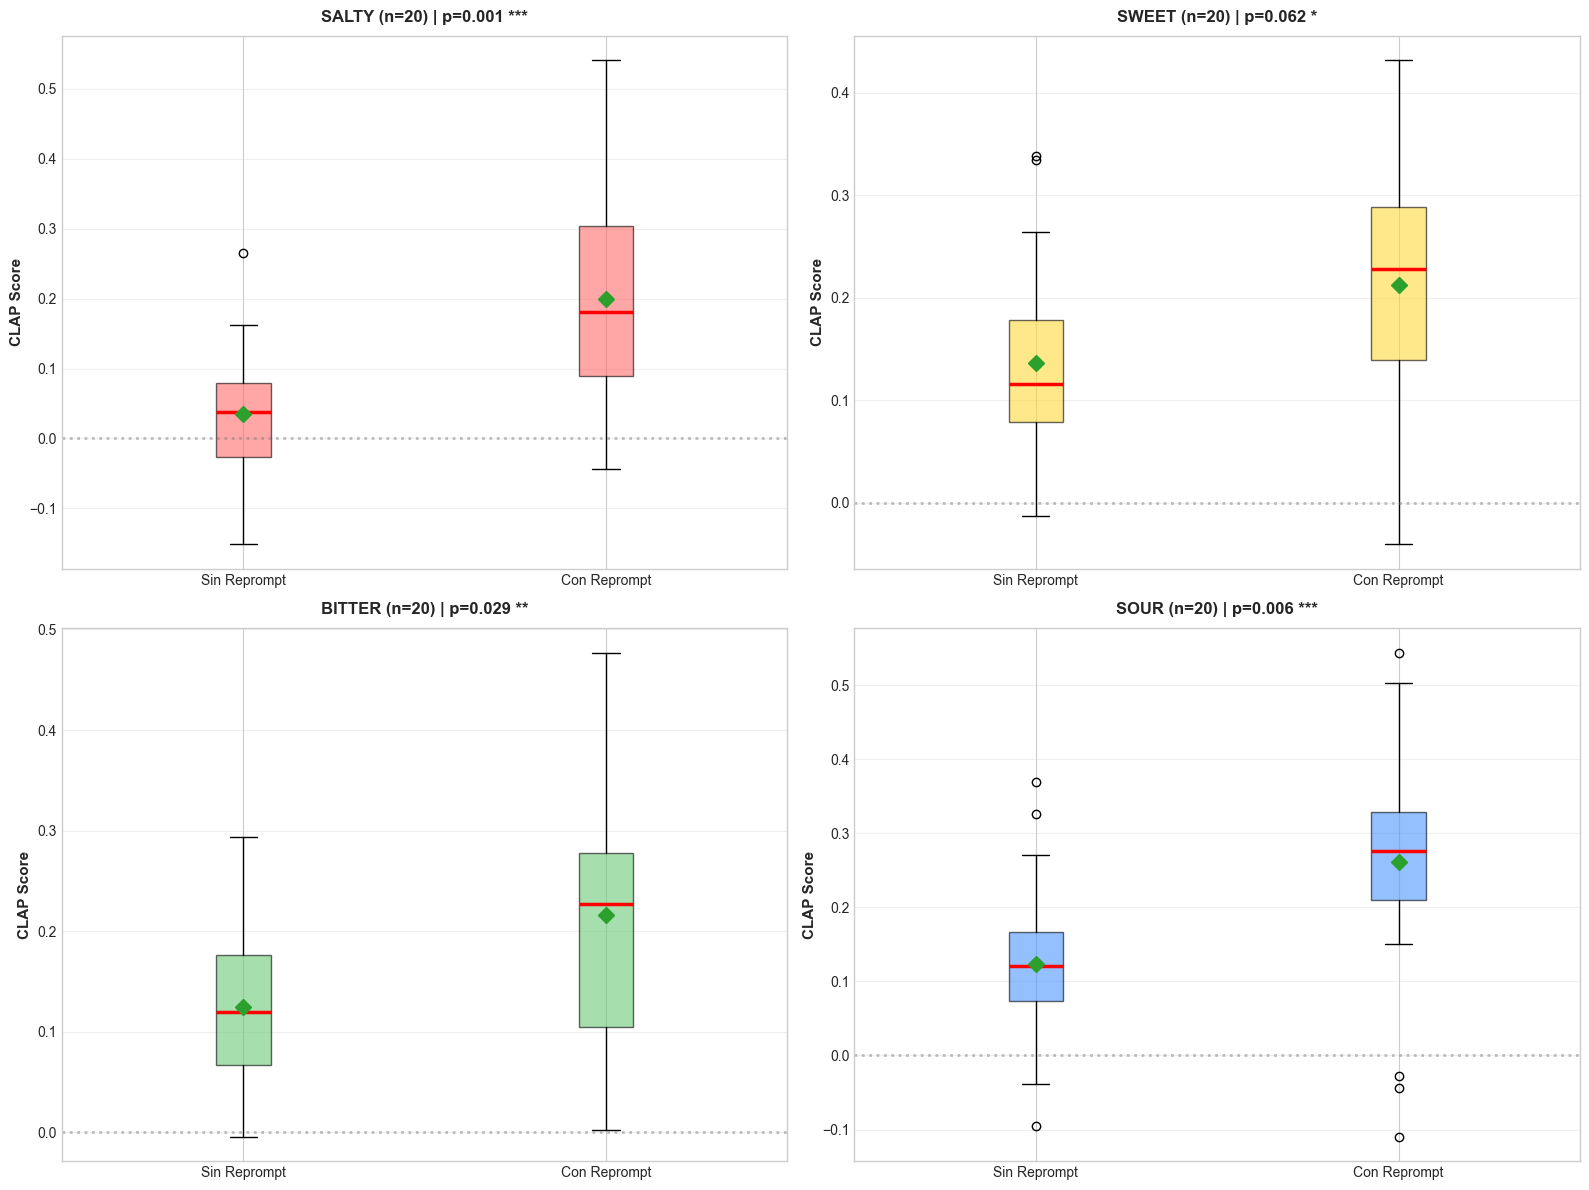

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

tastes = ['salty', 'sweet', 'bitter', 'sour']
colors = ['#FF6B6B', '#FFD93D', '#6BCB77', '#4D96FF']

for idx, (taste, color) in enumerate(zip(tastes, colors)):
    ax = axes[idx // 2, idx % 2]
    subset = comparison_df[comparison_df['taste'] == taste]

    data_to_plot = [subset['clap_score_sin_reprompt'],
                    subset['clap_score_con_reprompt']]

    bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
                    patch_artist=True, showmeans=True,
                    boxprops=dict(facecolor=color, alpha=0.6),
                    medianprops=dict(color='red', linewidth=2.5),
                    meanprops=dict(color='darkgreen', linewidth=2.5, 
                                  linestyle='--', marker='D', markersize=8))

    ax.axhline(y=0, color='gray', linestyle=':', linewidth=2, alpha=0.5)
    ax.set_ylabel('CLAP Score', fontsize=11, fontweight='bold')

    _, p_val = stats.ttest_rel(subset['clap_score_sin_reprompt'],
                                subset['clap_score_con_reprompt'])
    sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.10 else 'ns'

    ax.set_title(f'{taste.upper()} (n={len(subset)}) | p={p_val:.3f} {sig}',
                fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Proporción de Mejoras vs Empeoramientos

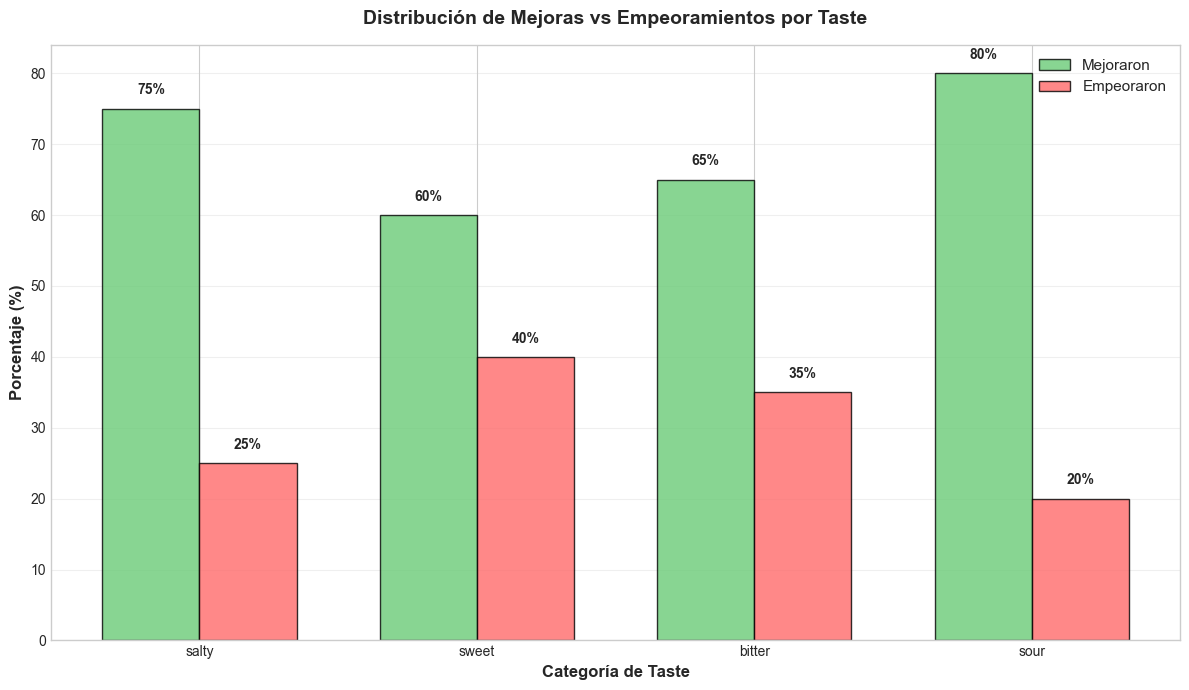

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(summary_taste_df))
width = 0.35

mejoraron = summary_taste_df['Mejoraron']
empeoraron = 100 - mejoraron

bars1 = ax.bar(x - width/2, mejoraron, width, label='Mejoraron', 
               color='#6BCB77', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, empeoraron, width, label='Empeoraron',
               color='#FF6B6B', alpha=0.8, edgecolor='black')

ax.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Categoría de Taste', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Mejoras vs Empeoramientos por Taste', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(summary_taste_df['Taste'])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')


for i, (mej, emp) in enumerate(zip(mejoraron, empeoraron)):
    ax.text(i - width/2, mej + 2, f'{mej:.0f}%', ha='center', fontsize=10, fontweight='bold')
    ax.text(i + width/2, emp + 2, f'{emp:.0f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Correlación de Kendall por Taste

Evaluamos la correlación entre scores de prompt y reprompt por categoría:

In [9]:
kendall_results = []
for taste in ['salty', 'sweet', 'bitter', 'sour']:
    subset = comparison_df[comparison_df['taste'] == taste]
    tau, p_val = stats.kendalltau(subset['clap_score_sin_reprompt'],
                                    subset['clap_score_con_reprompt'])
    kendall_results.append({
        'Taste': taste,
        'N': len(subset),
        'Kendall_τ': tau,
        'p_value': p_val,
        'Interpretación': 'Fuerte' if abs(tau) > 0.6 else 'Moderada' if abs(tau) > 0.3 else 'Débil'
    })

kendall_df = pd.DataFrame(kendall_results).round(4)
kendall_df

,Taste,N,Kendall_τ,p_value,Interpretación
0,salty,20,0.1053,0.5424,Débil
1,sweet,20,-0.1368,0.4223,Débil
2,bitter,20,-0.1368,0.4223,Débil
3,sour,20,0.0211,0.9235,Débil


**Interpretación**: Correlaciones de Kendall más bajas indican mayor independencia entre prompt y reprompt para esa categoría.

## 5. Casos Extremos por Categoría

### Top Mejoras y Empeoramientos por Taste

In [8]:
for taste in ['salty', 'sweet', 'bitter', 'sour']:
    subset = comparison_df[comparison_df['taste'] == taste].copy()

    print(f"TASTE: {taste.upper()} (n={len(subset)})")

    if len(subset) >= 3:
        print(f"Top 3 Mejoras: \n")
        top_mejoras = subset.nlargest(3, 'diferencia_reprompt')[
            ['id_prompt', 'food', 'clap_score_sin_reprompt', 
             'clap_score_con_reprompt', 'diferencia_reprompt']
        ].round(4)
        display(top_mejoras)

        print(f" Top 3 Empeoramientos: \n")
        top_empeoramientos = subset.nsmallest(3, 'diferencia_reprompt')[
            ['id_prompt', 'food', 'clap_score_sin_reprompt', 
             'clap_score_con_reprompt', 'diferencia_reprompt']
        ].round(4)
        display(top_empeoramientos)
    else:
        print(f"Todos los casos: \n")
        display(subset[['id_prompt', 'food', 'clap_score_sin_reprompt', 
                        'clap_score_con_reprompt', 'diferencia_reprompt']].round(4))

TASTE: SALTY (n=20)
Top 3 Mejoras: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
55,56,bowl of miso soup,-0.1515,0.5412,0.6928
45,46,bowl of miso soup,0.0495,0.4392,0.3897
51,52,soft pretzel,0.0639,0.4472,0.3833


 Top 3 Empeoramientos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
46,47,beef jerky,0.0467,-0.0251,-0.0718
52,53,basket of french fries,0.1626,0.1240,-0.0386
53,54,salted peanuts,-0.0139,-0.0434,-0.0295


TASTE: SWEET (n=20)
Top 3 Mejoras: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
16,17,fruit salad,0.0336,0.4316,0.3980
4,5,apple pie,0.1090,0.4117,0.3027
19,20,blueberry muffin,0.0285,0.2829,0.2544


 Top 3 Empeoramientos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
13,14,honey glazed bun,0.1540,-0.0404,-0.1944
7,8,cinnamon roll,0.2645,0.1097,-0.1547
10,11,chocolate cake,0.3378,0.2194,-0.1184


TASTE: BITTER (n=20)
Top 3 Mejoras: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
35,36,bitter melon stir-fry,0.0135,0.4496,0.4361
37,38,matcha latte,0.0980,0.4770,0.3789
20,21,dark chocolate bar,0.0118,0.3840,0.3722


 Top 3 Empeoramientos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
26,27,grapefruit slice,0.2129,0.0073,-0.2056
21,22,black coffee,0.1846,0.0495,-0.1351
36,37,grapefruit slice,0.1301,0.0019,-0.1283


TASTE: SOUR (n=20)
Top 3 Mejoras: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
77,78,green apple,-0.0173,0.5035,0.5208
79,80,bowl of ceviche,-0.0381,0.4302,0.4683
76,77,glass of cranberry juice,0.1609,0.5440,0.3832


 Top 3 Empeoramientos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
64,65,slice of sourdough bread,0.2090,-0.0439,-0.2528
71,72,bowl of greek yogurt,0.0091,-0.1100,-0.1190
78,79,glass of lemonade,0.3688,0.2561,-0.1127


## 7. Conclusiones

### Hallazgos Clave por Categoría de Taste

**1. SALTY (n=20): Mayor Beneficio del Reprompt**
- Mejora más significativa estadísticamente (p = 0.0012 < 0.01)
- Mejora promedio: +479% en CLAP score (+0.1653 puntos)
- 75% de los prompts mejoraron con reprompt
- Correlación Kendall débil (τ = 0.105) indica independencia entre ambas condiciones
- Caso destacado: bowl of miso soup (+0.6928 de mejora)

**2. SOUR (n=20): Segundo Mayor Impacto**
- Mejora altamente significativa (p = 0.0059 < 0.01)
- 80% de los prompts mejoraron (mayor porcentaje de mejora)
- Cambio promedio: +111% (+0.1371 puntos)
- Correlación Kendall muy débil (τ = 0.021) indica transformación sustancial
- Casos destacados: green apple (+0.5208), bowl of ceviche (+0.4683)

**3. BITTER (n=20): Beneficio Moderado Significativo**
- Mejora estadísticamente significativa (p = 0.0285 < 0.05)
- 65% de los prompts mejoraron
- Cambio promedio: +74% (+0.0921 puntos)
- Correlación Kendall débil negativa (τ = -0.137)
- Casos destacados: bitter melon stir-fry (+0.4361), matcha latte (+0.3789)

**4. SWEET (n=20): Beneficio Marginal No Significativo**
- Tendencia positiva marginal (p = 0.0619, no significativo al 5%)
- 60% de los prompts mejoraron (menor porcentaje)
- Cambio promedio: +56% (+0.0760 puntos)
- Correlación Kendall débil negativa (τ = -0.137)
- Mayor variabilidad: algunos casos empeoran significativamente

---


El reprompting incrementa el CLAP score medio general de 0.1047 a 0.2224 (+0.1177 puntos, +112%). 

Este beneficio varía significativamente por categoría de taste:

1. **Categorías con beneficio estadísticamente significativo**: salty (p<0.01), sour (p<0.01), bitter (p<0.05)
2. **Categoría con beneficio marginal no significativo**: sweet (p=0.062)
3. **Patrón general**: Las categorías con CLAP scores iniciales más bajos (salty: 0.0345) experimentan mayores mejoras relativas
4. **Correlaciones débiles**: La ausencia de correlación significativa entre prompts y reprompts indica que el reprompting transforma sustancialmente la representación texto-audio en todas las categorías
